In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"]=(20,20)

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision.utils import make_grid

from RBM import RBM
from DAE import DAE

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Load MNIST 

In [3]:
flattenTransform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Lambda(lambda x: torch.flatten(x))])
MNISTTrain = torchvision.datasets.MNIST(root="./dataset/", train=True, transform=flattenTransform, download=True)
MNISTTest = torchvision.datasets.MNIST(root="./dataset/", train=False, transform=flattenTransform, download=True)

batchSize = 128
trainData = DataLoader(MNISTTrain, batch_size=batchSize, shuffle=True)
testData = DataLoader(MNISTTest, batch_size=batchSize, shuffle=True)

In [4]:
def displayOutput(a, b, dim=(28, 28), maxDisplay = 10, title=None, fileName=None):
    fig, axs = plt.subplots(1,2)
    for i, data in enumerate((a, b)):
        viewAsImage = data.view(data.shape[0], 1, dim[0], dim[1])
        # use sqrt to compute max squared size length before makeGrid
        # sideSize = min(int(math.sqrt(len(viewAsImage))), maxDisplay)
        # img = make_grid(viewAsImage[:sideSize*sideSize].data, nrow = sideSize).detach().cpu().numpy()
        img = make_grid(viewAsImage.data).detach().cpu().numpy()
        axs[i].imshow(np.transpose(img, (1, 2, 0)))

    if title is not None: fig.suptitle(title)
    if fileName is not None: plt.savefig(fileName)
    plt.show()

In [5]:
MSELossSum = torch.nn.MSELoss(reduction='sum')
def batchLoss(a, b, batchSize):
    return MSELossSum(a,b)/batchSize

In [6]:
def trainRBM(rbm, dataLoader, epochs, learningRate, weightDecay=2e-4):
    paddingLength = 1+int(math.log10(epochs)) # for padded print
    
    for epoch in range(epochs):
        epochLoss = 0
        for i, (data, _) in enumerate(dataLoader): # we will use only data
            Vp0 = data.to(device)
            # Vs0 = torch.bernoulli(Vp0)
            # V: Visible | H: Hidden
            # s: sampling | p: probabilities
            # 0: start | k:end
            
            Vpk, Vsk = rbm.gibbsSampling(Vp0, iterations = 1) #Vs0
              
            Hp0, _ = rbm.sampleHidden(Vp0) #Vs0
            Hpk, _ = rbm.sampleHidden(Vpk) #Vsk
            
            rbm.contrastiveDivergence(Vp0, Vpk, Hp0, Hpk, learningRate = learningRate, weightDecay = weightDecay, momentumDamping = 0.5 if epoch < 5 else 0.9)

            epochLoss += batchLoss(Vp0, Vpk, batchSize)

        if epoch % (epochs/10) == (epochs/10-1):
            print(f"  Epoch[{epoch+1:>{paddingLength}}] Avg. Loss: {epochLoss / len(dataLoader):.5f}")
        
    return

In [7]:
def genNewDataSet(rbm, device, dataLoader):
    # rederive new data loader based on hidden activations of trained model
    newData = []
    for data, _ in dataLoader:
        Hp, _ = rbm.sampleHidden(data.to(device))
        newData.append(Hp.detach().cpu().numpy())
    newData = np.concatenate(newData)
    fakesLabels = np.zeros((len(newData), 1))
    return DataLoader(TensorDataset(torch.Tensor(newData).to(device), torch.Tensor(fakesLabels).to(device)), batch_size=dataLoader.batch_size, shuffle=True)


In [8]:
# use much lower learning for last gaussian layer to avoid exploding gradient
# use a Gaussian distribution for the last hidden layer to let it take advantage of continuous values
# 784-1000-500-250-3

epochsF = lambda x: x + 10
RMBLayersTrainingInfos = [
    { "hiddenDim": 1000, "numEpochs": epochsF(10), "learningRate":   0.1, "displayDim": (28, 28), "useGaussian": False}, 
    { "hiddenDim":  500, "numEpochs": epochsF(20), "learningRate":  0.05, "displayDim": (25, 40), "useGaussian": False},
    { "hiddenDim":  250, "numEpochs": epochsF(30), "learningRate":  0.01, "displayDim": (25, 20), "useGaussian": False},
    { "hiddenDim":    3, "numEpochs": epochsF(60), "learningRate": 0.001, "displayDim": (25, 10), "useGaussian": True}
]

## Training RBM


Train layer 784-1000 (20 Epochs):
  Initial first batch loss: 258.99551
  Epoch[ 2] Avg. Loss: 9.11003
  Epoch[ 4] Avg. Loss: 7.80357
  Epoch[ 6] Avg. Loss: 7.77220
  Epoch[ 8] Avg. Loss: 7.00185
  Epoch[10] Avg. Loss: 6.72955
  Epoch[12] Avg. Loss: 6.54372
  Epoch[14] Avg. Loss: 6.42682
  Epoch[16] Avg. Loss: 6.35871
  Epoch[18] Avg. Loss: 6.28797
  Epoch[20] Avg. Loss: 6.23502


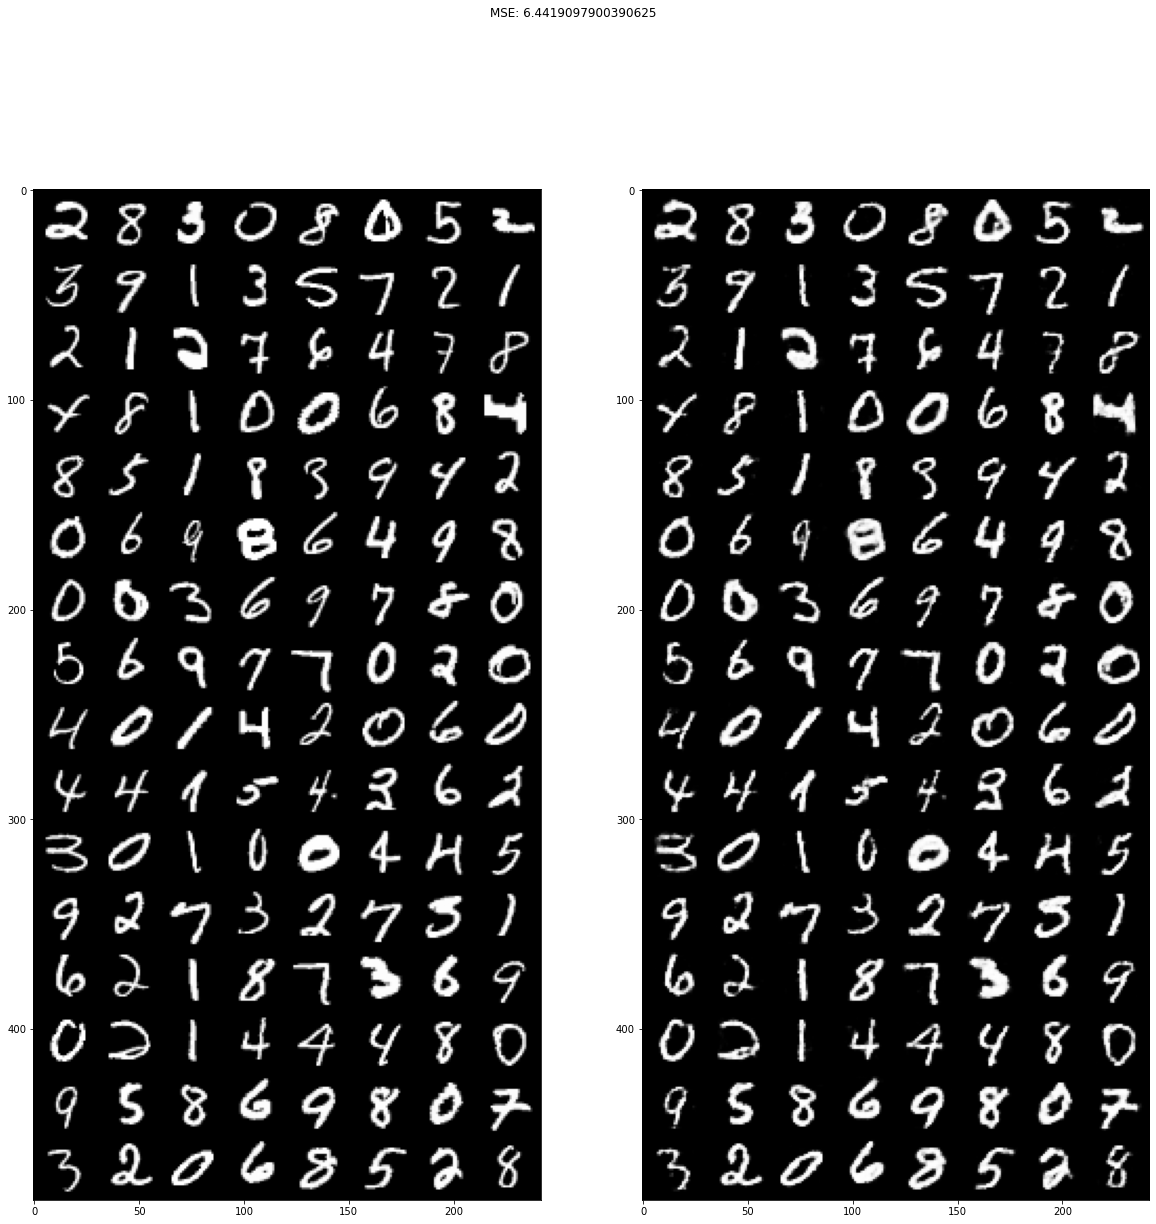


Train layer 1000-500 (30 Epochs):
  Initial first batch loss: 235.87039
  Epoch[ 3] Avg. Loss: 13.23385
  Epoch[ 6] Avg. Loss: 10.36272
  Epoch[ 9] Avg. Loss: 7.42472
  Epoch[12] Avg. Loss: 6.53839
  Epoch[15] Avg. Loss: 6.16399
  Epoch[18] Avg. Loss: 5.94983
  Epoch[21] Avg. Loss: 5.81483
  Epoch[24] Avg. Loss: 5.73572
  Epoch[27] Avg. Loss: 5.68083
  Epoch[30] Avg. Loss: 5.65310


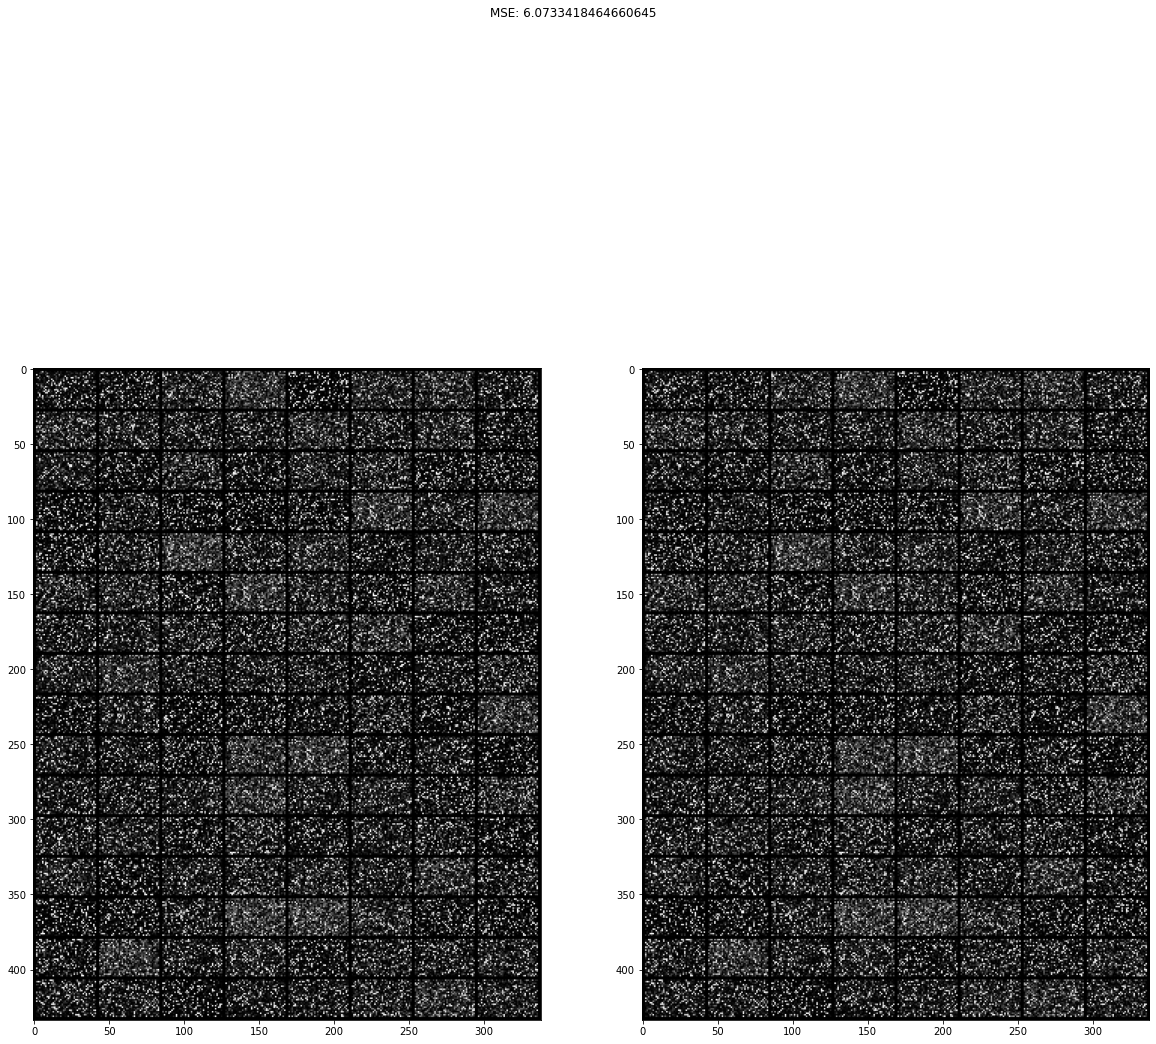


Train layer 500-250 (40 Epochs):
  Initial first batch loss: 115.62166
  Epoch[ 4] Avg. Loss: 13.84299
  Epoch[ 8] Avg. Loss: 8.36536
  Epoch[12] Avg. Loss: 7.20244
  Epoch[16] Avg. Loss: 6.73308
  Epoch[20] Avg. Loss: 6.46512
  Epoch[24] Avg. Loss: 6.26856
  Epoch[28] Avg. Loss: 6.13596
  Epoch[32] Avg. Loss: 6.04252
  Epoch[36] Avg. Loss: 5.96764
  Epoch[40] Avg. Loss: 5.90331


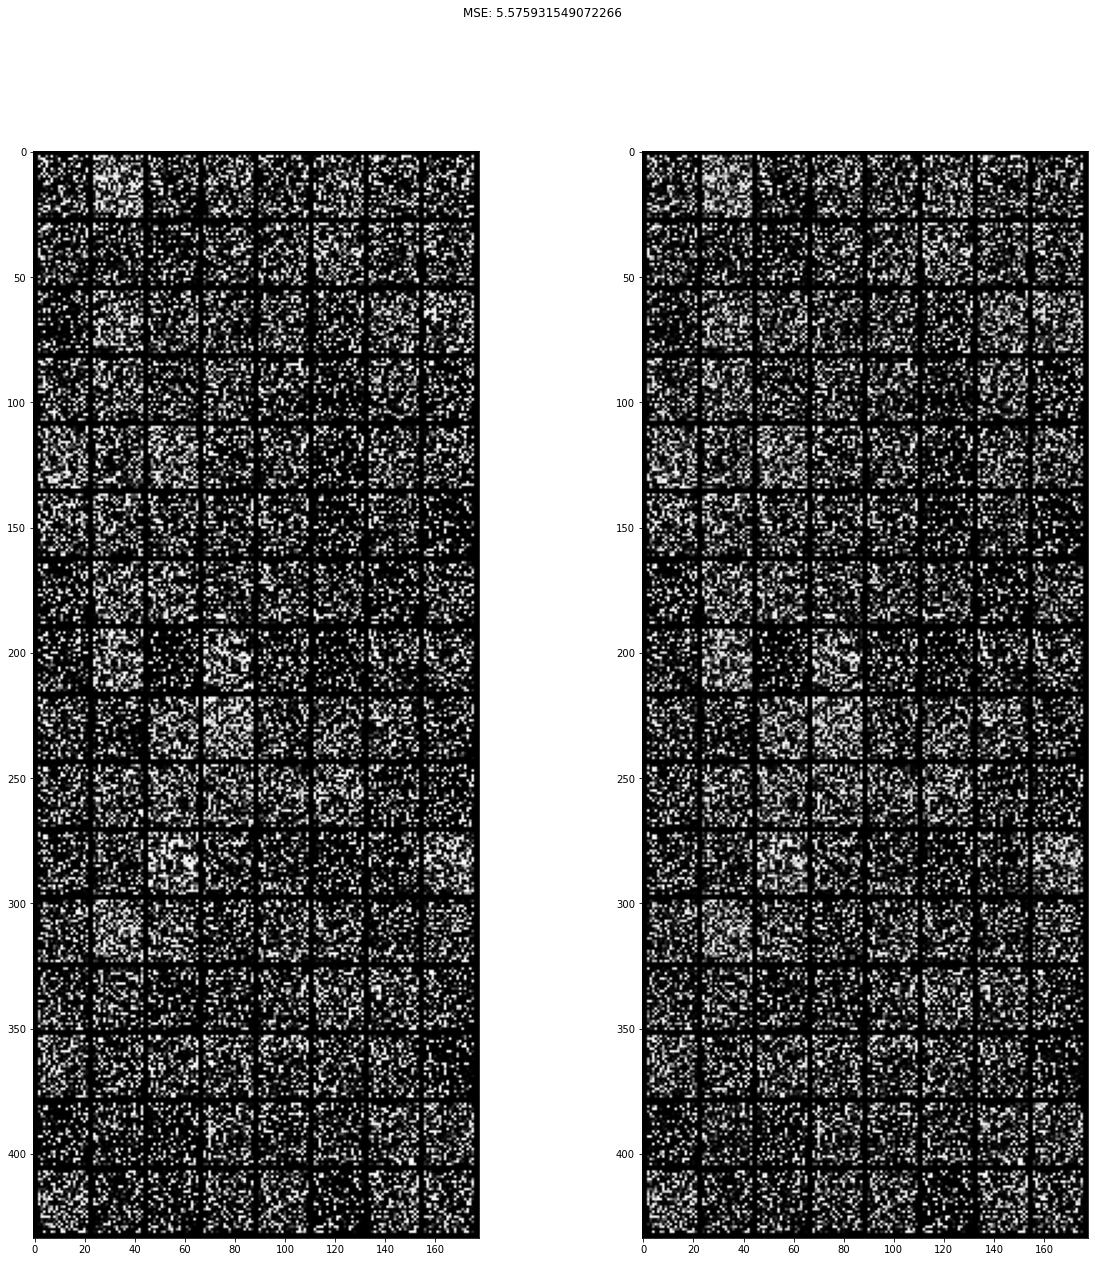


Train layer 250-3 (70 Epochs):
  Initial first batch loss: 45.12613
  Epoch[ 7] Avg. Loss: 32.42560
  Epoch[14] Avg. Loss: 32.18913
  Epoch[21] Avg. Loss: 32.18810
  Epoch[28] Avg. Loss: 32.18748
  Epoch[35] Avg. Loss: 32.19062
  Epoch[42] Avg. Loss: 32.18668
  Epoch[49] Avg. Loss: 32.18613
  Epoch[56] Avg. Loss: 32.18473
  Epoch[63] Avg. Loss: 32.18552
  Epoch[70] Avg. Loss: 32.19021


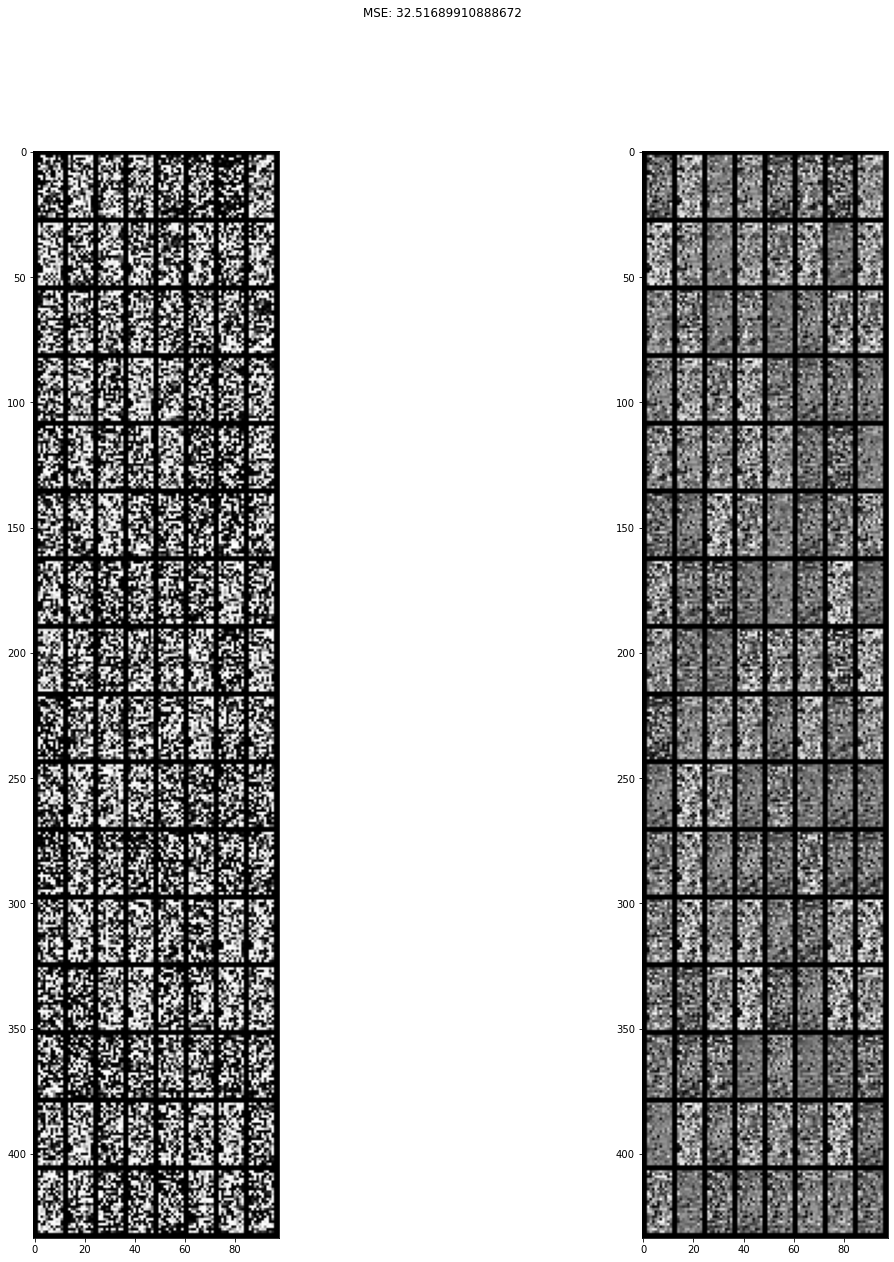

In [9]:
dataLoader = trainData # get initial iteration of new training data
visibleDim = next(iter(dataLoader))[0].shape[1] # set starting visible dim
hiddenDim = None
RBMLayers = [] # trained RBM models

Display = True
for configs in RMBLayersTrainingInfos:
    hiddenDim = configs["hiddenDim"]  # update hidenDim
    numEpochs = configs["numEpochs"]
    print(f"\nTrain layer {visibleDim}-{hiddenDim} ({numEpochs} Epochs):")
    
    # create rbm layers
    rbm = RBM(device, visibleDim, hiddenDim, gaussianHiddenDistribution=configs["useGaussian"], useMomentum = True)
    
    # print initial loss
    data = next(iter(dataLoader))[0].to(device)
    reconstructedVp, _ = rbm.reconstruct(data)
    print(f"  Initial first batch loss: {batchLoss(data, reconstructedVp, batchSize):.5f}")
    
    trainRBM(rbm, dataLoader, numEpochs, configs["learningRate"], weightDecay=2e-4)

    # display sample output
    if Display:
        data = next(iter(dataLoader))[0].to(device)
        reconstructedVp, _ = rbm.reconstruct(data)
        displayOutput(data, reconstructedVp, configs["displayDim"], title=f'MSE: {batchLoss(data, reconstructedVp, batchSize).item()}')

    RBMLayers.append(rbm)
    dataLoader = genNewDataSet(rbm, device, dataLoader) # generate new data based on this layer
    visibleDim = hiddenDim # update new visibleDim for next RBM

## Build & fine-tune autoencoder

In [10]:
batchSize = 512 # use bigger batch size for fine tinning
dataLoader = DataLoader(MNISTTrain, batch_size=batchSize, shuffle=True)
learningRate = 1e-3
DAE = DAE(RBMLayers).to(device)
optimizer = optim.Adam(DAE.parameters(), learningRate)
numEpochs = 100

trackLoss = True
epochsLoss = []

c:\program files\python\lib\site-packages\torch\nn\modules\container.py:434: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


Epoch[ 10] Complete: Avg. Loss: 23.70835181
Epoch[ 20] Complete: Avg. Loss: 21.84904243
Epoch[ 30] Complete: Avg. Loss: 20.91094386
Epoch[ 40] Complete: Avg. Loss: 20.25773927
Epoch[ 50] Complete: Avg. Loss: 19.75604806
Epoch[ 60] Complete: Avg. Loss: 19.33949349
Epoch[ 70] Complete: Avg. Loss: 18.98173994
Epoch[ 80] Complete: Avg. Loss: 18.68732997
Epoch[ 90] Complete: Avg. Loss: 18.39442353
Epoch[100] Complete: Avg. Loss: 18.12362881


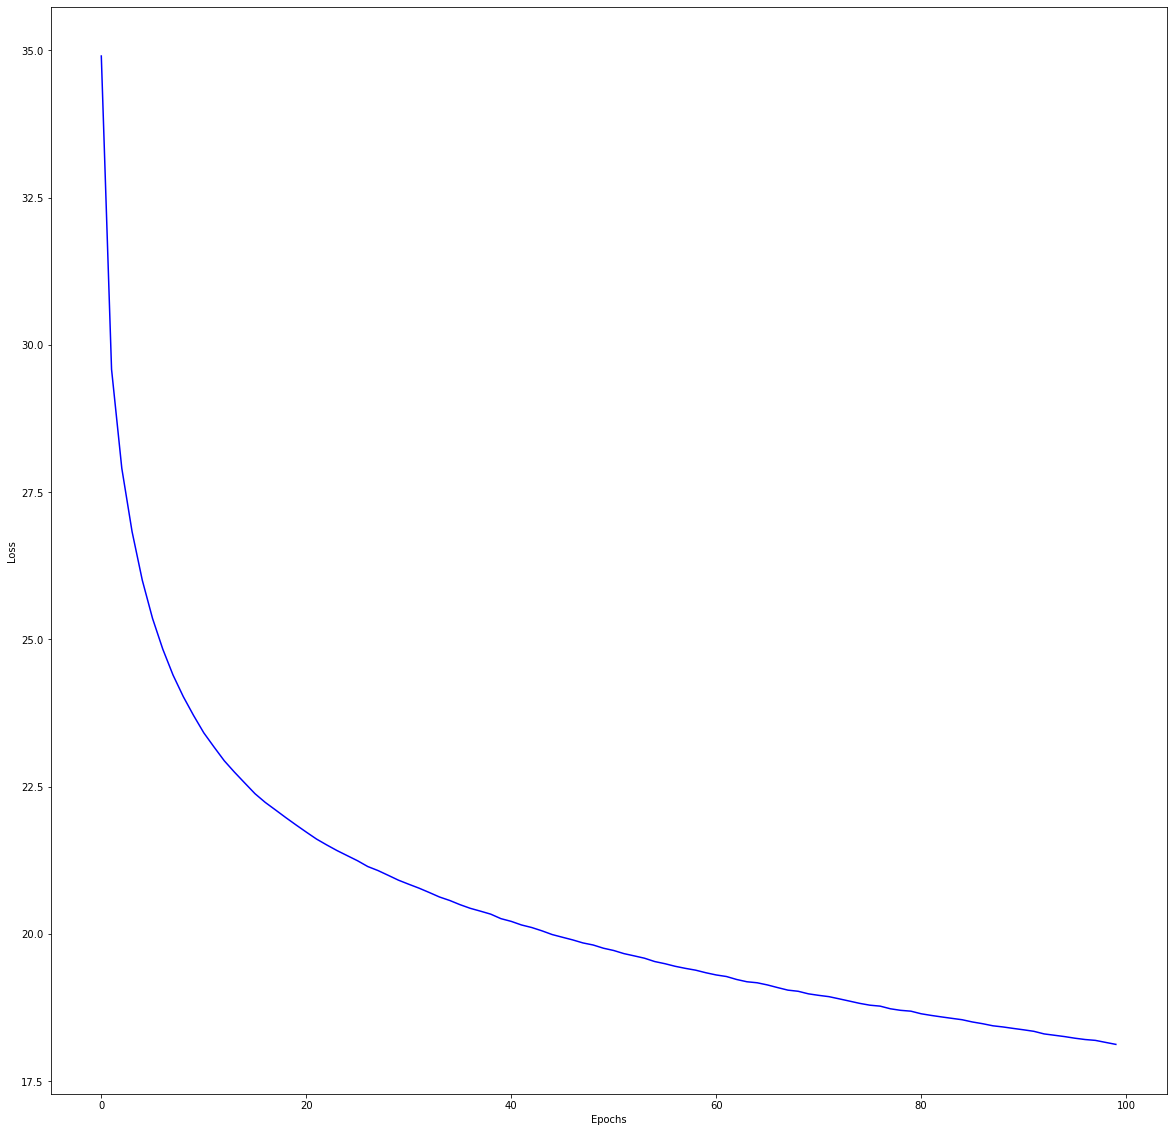

In [11]:
paddingLength = 1+int(math.log10(numEpochs)) # for padded print
for epoch in range(numEpochs):
    epochLoss = 0
    for batchIdx, (data, _) in enumerate(dataLoader):
        data = data.to(device) # to device

        optimizer.zero_grad() # zero the parameters gradients

        outputs = DAE(data) # forward

        lossValue = batchLoss(data, outputs, batchSize) # compute loss

        if(trackLoss): epochLoss += lossValue.item() # record loss

        lossValue.backward() # backward
        optimizer.step()

    epochLoss /= len(dataLoader)
    if(trackLoss): epochsLoss.append(epochLoss) # record loss
    
    if epoch % (numEpochs/10) == (numEpochs/10-1):
        print(f"Epoch[{epoch + 1:>{paddingLength}}] Complete: Avg. Loss: {epochLoss:.8f}")

if trackLoss: # display recored loss values
    plt.plot(epochsLoss, color='blue')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

In [12]:
def batchLossReport(dataLoader, model):
    lossValues = []
    model.eval() # Disable some specific layers/parts(Dropouts Layers, BatchNorm Layers, ...)
    with torch.no_grad():
        for inputs, _ in dataLoader:
            inputs = inputs.to(device=device)
            outputs = model(inputs)
            lossValues.append(batchLoss(inputs, outputs, dataLoader.batch_size))
    model.train()
    return lossValues

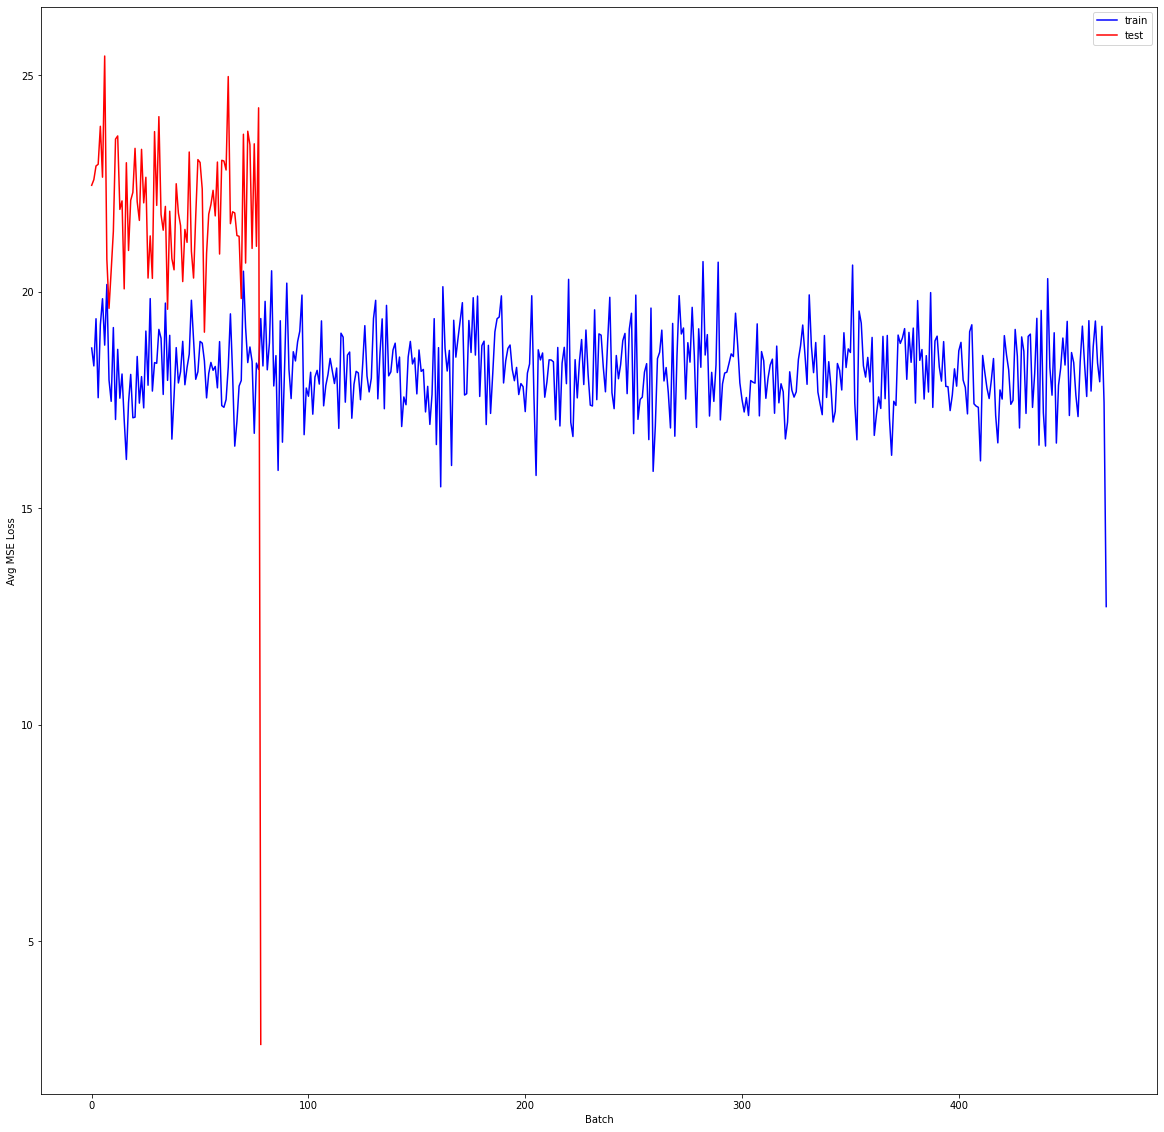

In [13]:
trainBatchLoss = batchLossReport(trainData, DAE)
testBatchLoss = batchLossReport(testData, DAE)

plt.plot(trainBatchLoss, color='blue', label = "train")
plt.plot(testBatchLoss, color='red', label = "test")
plt.xlabel('Batch')
plt.ylabel('Avg MSE Loss')
plt.legend(loc='upper right')
plt.show()

## Display results

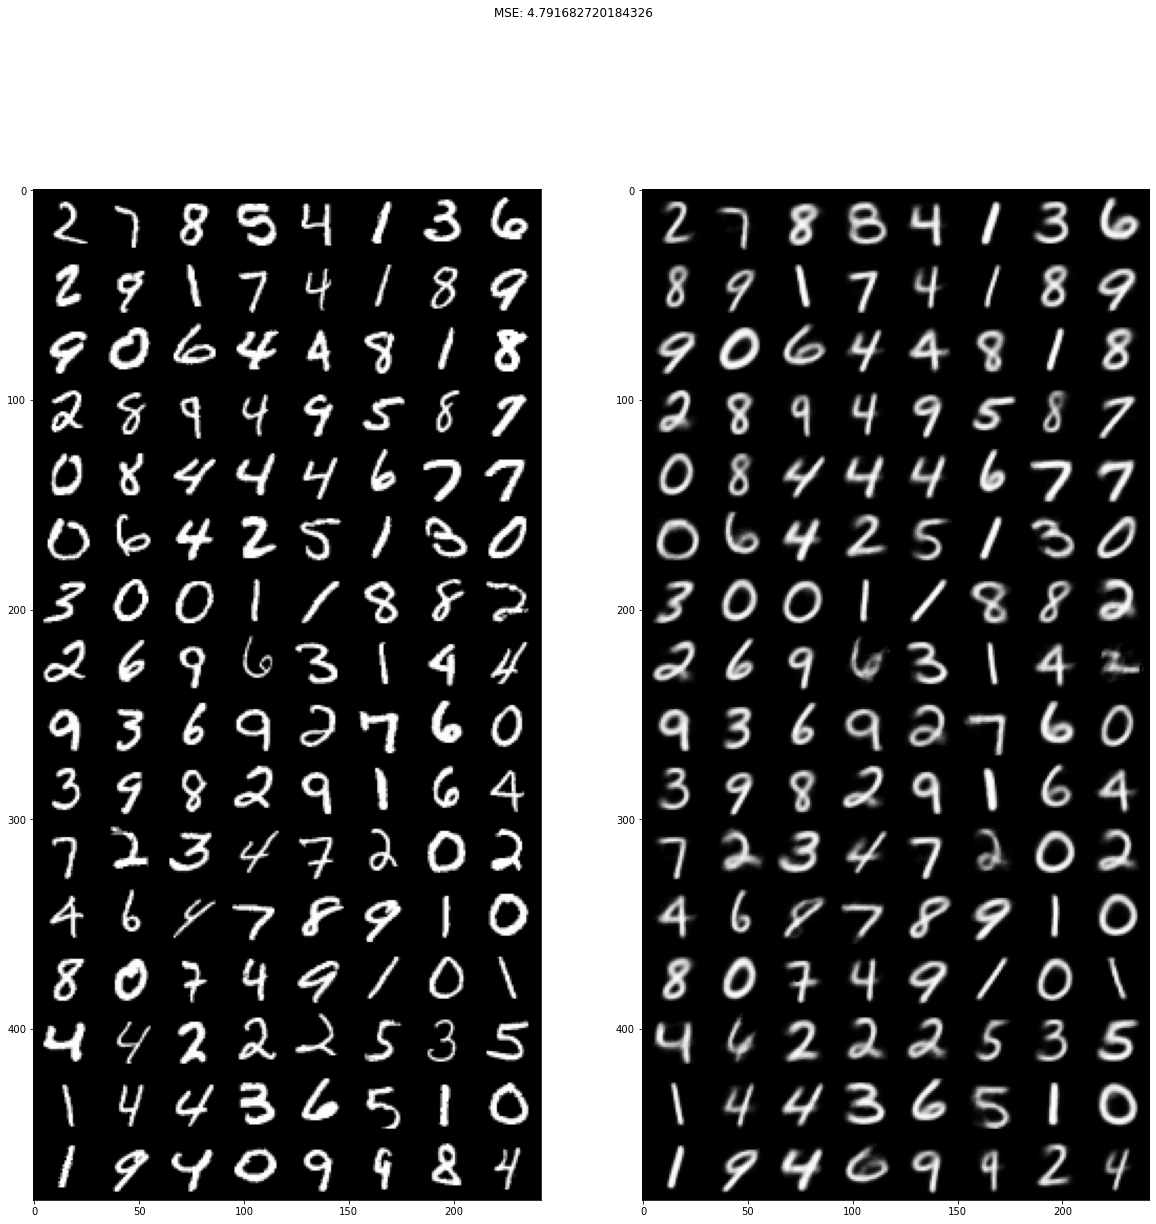

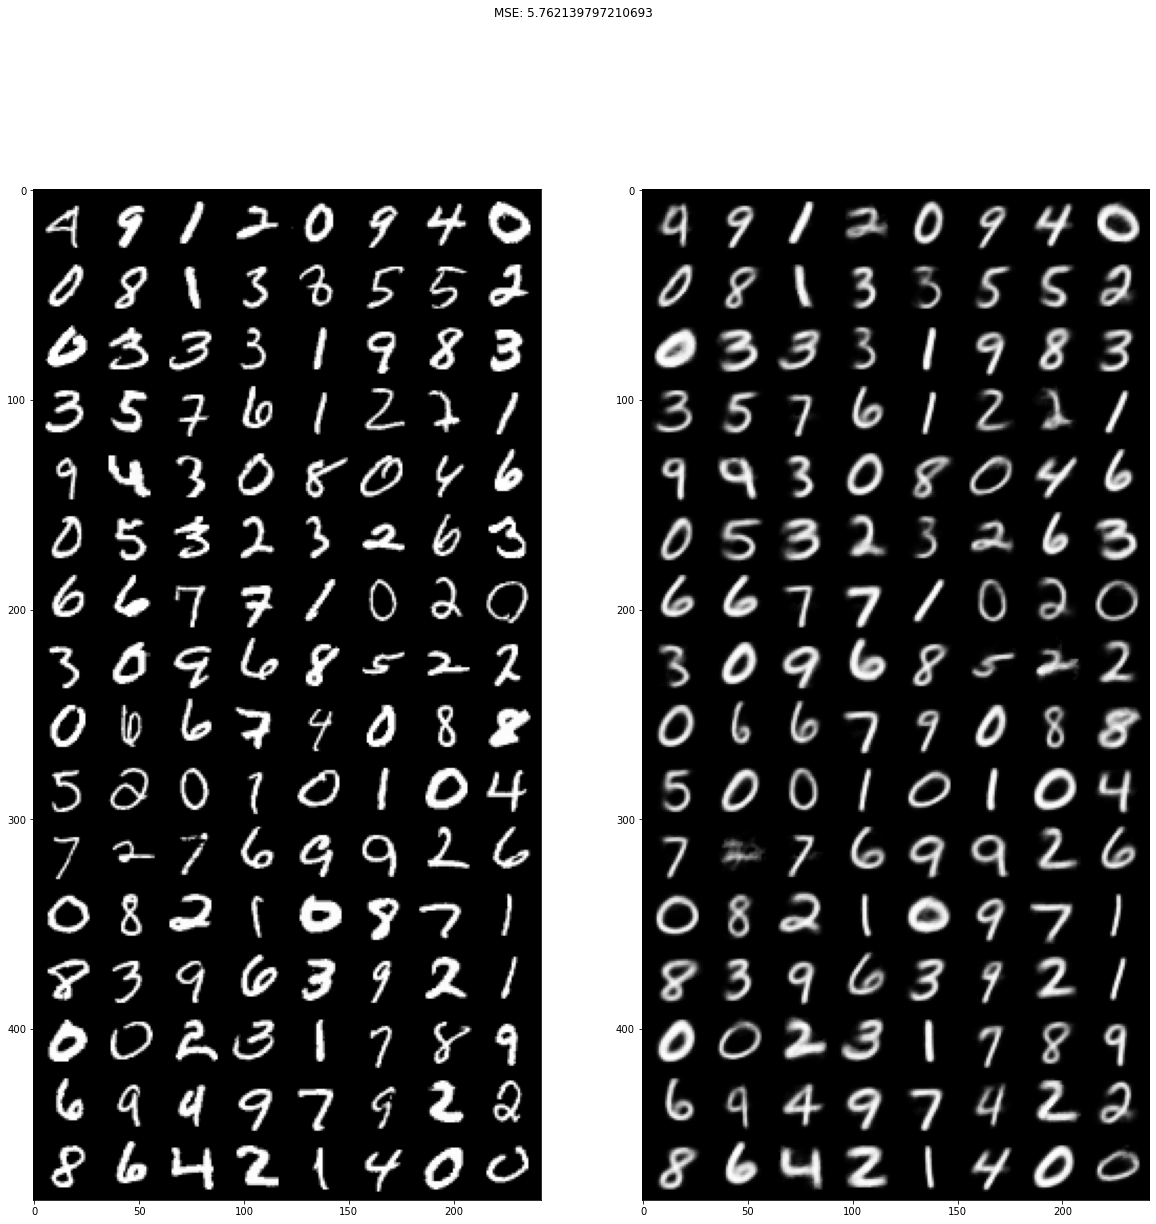

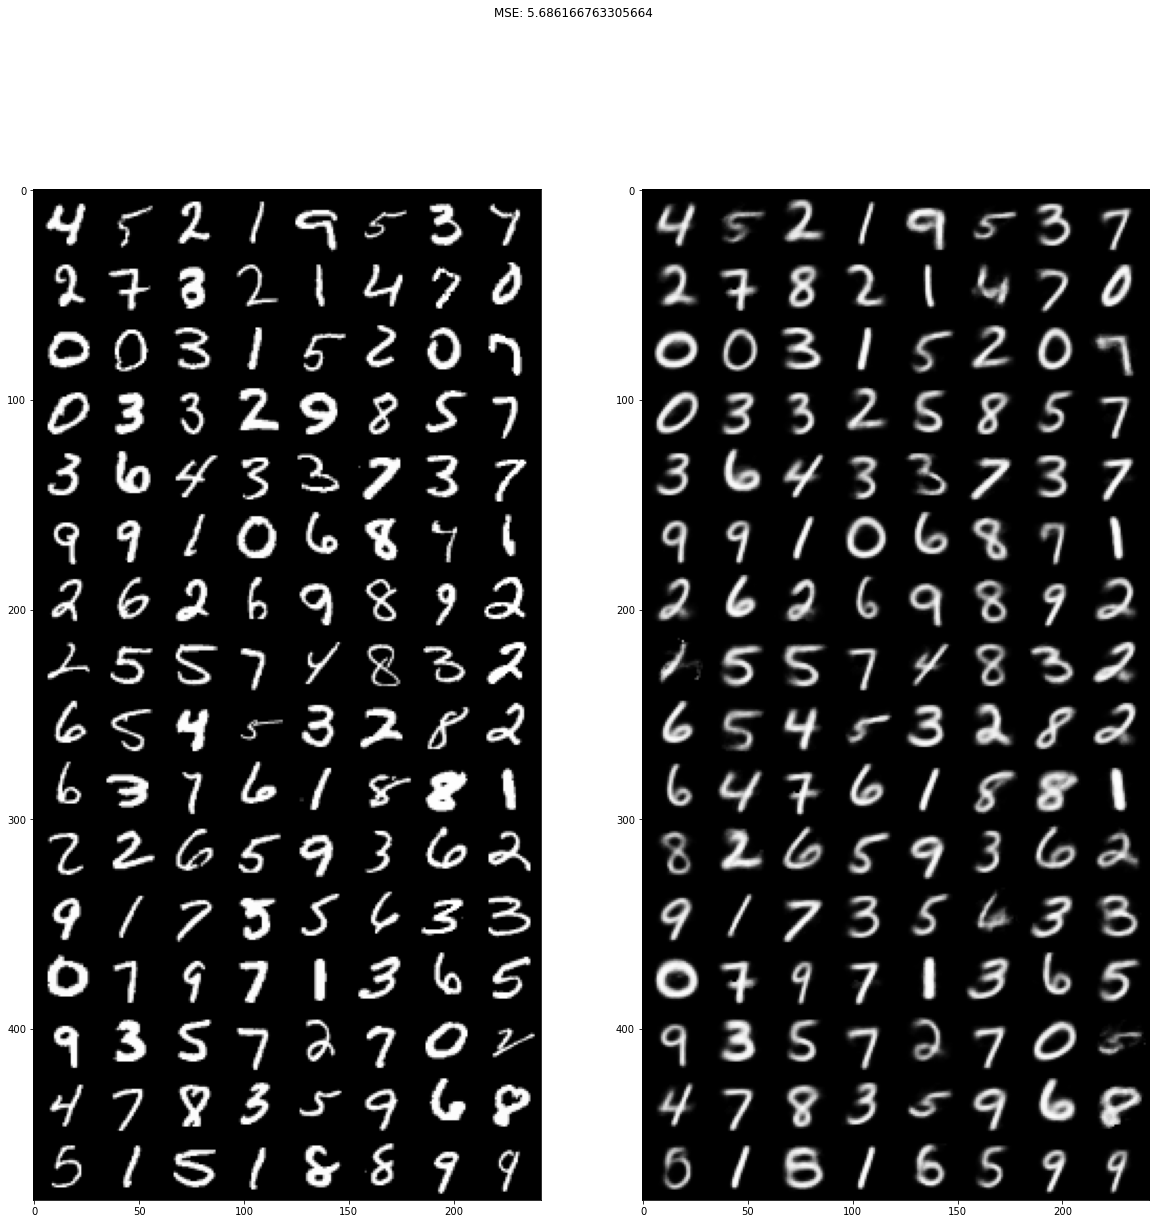

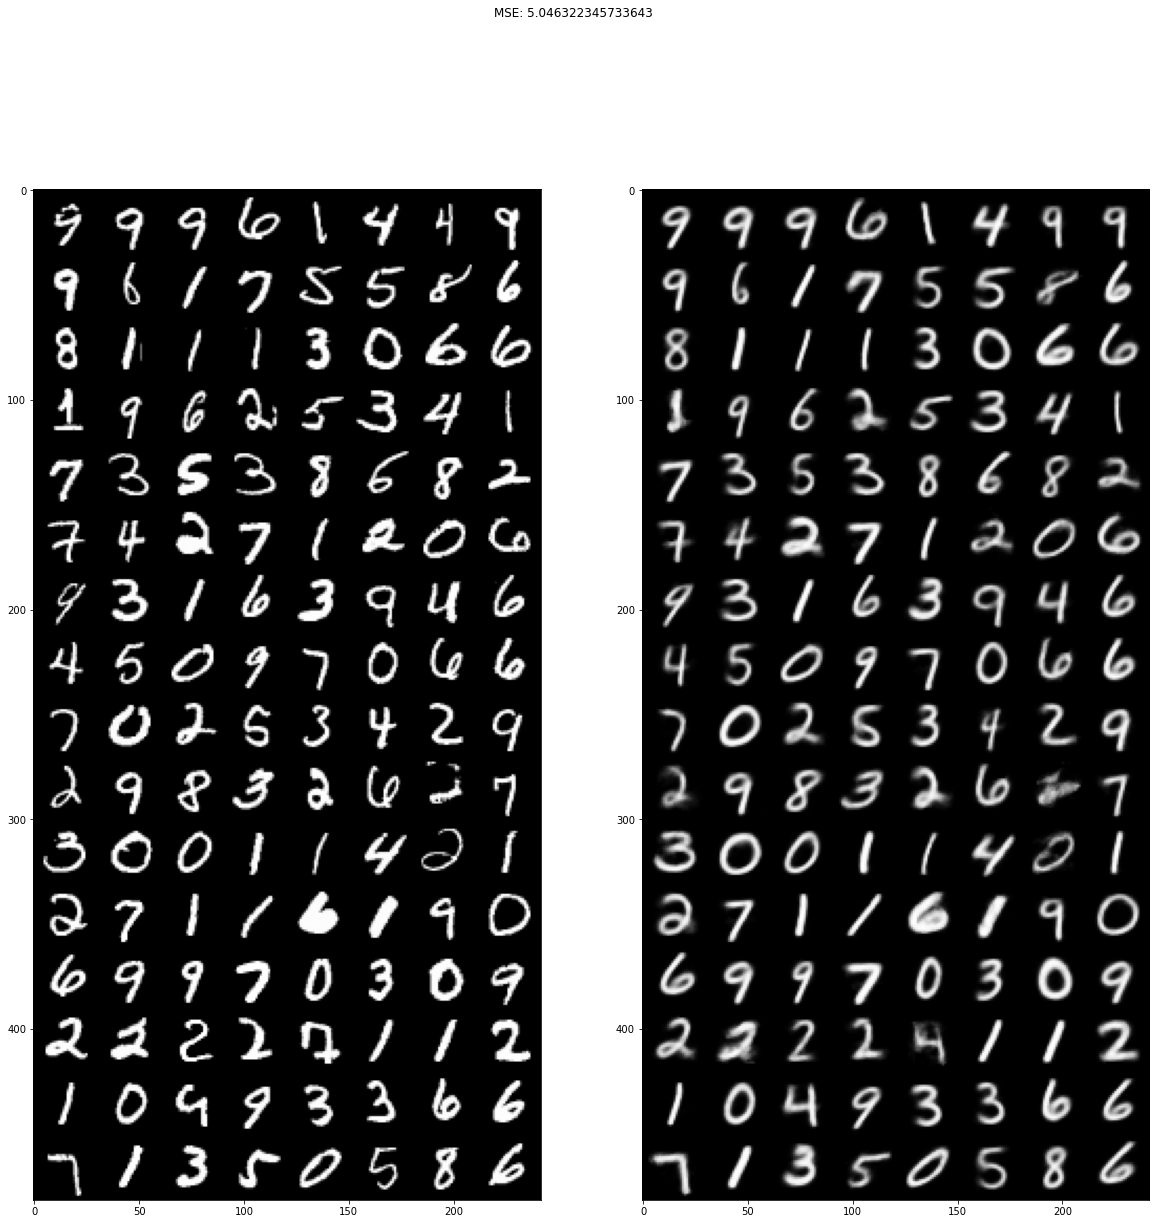

In [14]:
it = iter(testData)

for i in range(4):
    data, _ = next(it)
    data = data.to(device)
    outputs = DAE(data)
    displayOutput(data, outputs, (28, 28), title=f'MSE: {batchLoss(data, outputs, batchSize)}')